## Lesson 2 - Main Biomes

Name: Beatriz Vieira Nascimento - 211031628

Github: Beatrizvn

The objective of this article is to apply the knowledge acquired in Lesson 2 of the Fast.ai book by configuring a learning model that identifies the 3 differents biomes and also to place the model on Hugging Face.

## Step 0: Baixar e importar algumas depedencias



In [ ]:
# Você pode pular esta célula se já tiver instalado
!pip install -Uqq duckduckgo_search
!pip install -Uqq fastai
!pip install -Uqq fastbook

In [ ]:
import fastbook
from fastbook import *
from fastai.vision.widgets import *

## Step 1: Download images

In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

First, let's download an image of 'rain forest.'




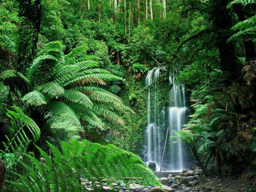

In [ ]:
from fastai.vision.all import *
from fastdownload import download_url

download_url(search_images('tropical rainforest', max_images=1)[0], 'rainforest.jpg', show_progress=False)
Image.open('rainforest.jpg').to_thumb(256,256)

Let's save each group of photos in a different folder.

In [ ]:
biomes = 'desert', 'tundra biome', 'tropical rainforest'
path = Path('biomesPath')

for o in biomes:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    resize_images(path/o, max_size=400, dest=path/o)

Our folder has image files

In [ ]:
fns = get_image_files(path)
fns

(#343) [Path('biomesPath/tundra biome/ab15ea49-92ad-45c3-8dd4-f0865325d60a.jpg'),Path('biomesPath/tundra biome/759027d7-e528-4545-b4b6-7aa234e297f2.jpg'),Path('biomesPath/tundra biome/98b576a4-43ff-4edd-bd2b-20176bf90303.jpg'),Path('biomesPath/tundra biome/b51aa564-158b-48bd-a178-26c00efc91ed.jpg'),Path('biomesPath/tundra biome/77702d83-642f-4d9c-a1ed-4764dd0ebf9c.jpg'),Path('biomesPath/tundra biome/a30724c8-cb10-4b36-bbed-abcd70baffeb.jpg'),Path('biomesPath/tundra biome/d2796e27-9c91-4661-9fb2-b8cd4944ed70.jpg'),Path('biomesPath/tundra biome/8ee1cc35-85e1-47e7-acb1-0ac2e589c35e.jpg'),Path('biomesPath/tundra biome/7706594f-9f78-4c75-be29-dfa68bad2dd6.jpg'),Path('biomesPath/tundra biome/d189b52e-a10f-4160-a910-ae55ddb44244.jpg')...]

Some photos may not be downloaded correctly, which can cause the model training to fail, so let's remove them:

In [ ]:
failed = verify_images(fns)
failed.map(Path.unlink);
failed

(#8) [Path('biomesPath/tundra biome/506de16c-8be0-4e68-b0de-292c2c0687dc.jpg'),Path('biomesPath/tundra biome/cb937526-fa21-4b1d-9752-0f5e924842c0.JPG'),Path('biomesPath/tundra biome/3b7e4f7e-e400-4b28-b141-7304a0e2962e.jpg'),Path('biomesPath/tropical rainforest/fbb021cf-1551-43ce-9552-92303e33c63e.jpg'),Path('biomesPath/desert/dae0c219-5889-422c-b0a4-3a500c2e535d.jpg'),Path('biomesPath/desert/6e854f4b-6b72-4bc0-9228-6c90b8afaba1.jpg'),Path('biomesPath/desert/a44bd1a3-ecb6-4755-886d-6e0ec1f08be7.jpg'),Path('biomesPath/desert/4cf42693-2e29-49b8-857b-aa925003699b.jpg')]

To train a model, we will need DataLoaders, which is an object containing a `training set` (the images used to create a model) and a validation set (the images used to assess the accuracy of a model - not used during training).

In fastai, we can easily create this using a `DataBlock` and visualize sample images from it:

In [ ]:
biomes = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))

dls = biomes.dataloaders(path)

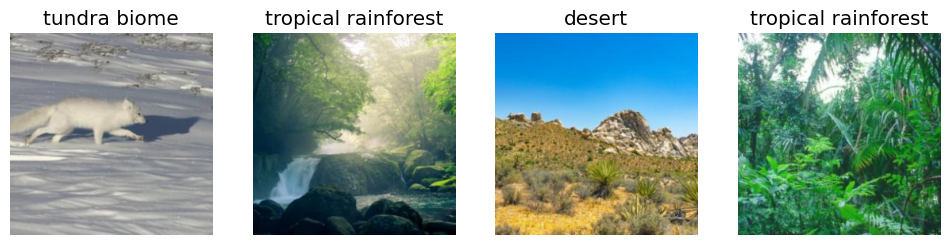

In [ ]:
dls.valid.show_batch(max_n=4, nrows=1)


## Step 2: Data Augmentation

*Data augmentation* refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes.

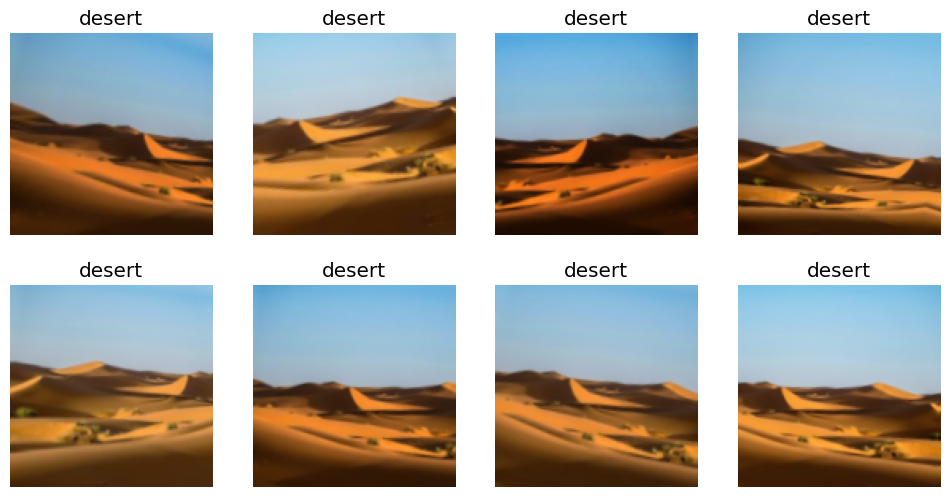

In [ ]:
biomes = biomes.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = biomes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Step 3: Treinando o modelo e limpando dados

Now we are ready to train our model.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Now let's see whether the mistakes the model is making, to visualize this, we can create a *confusion matrix*:

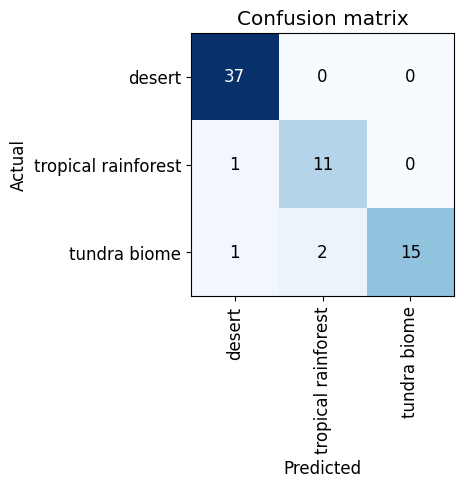

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

For now, `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

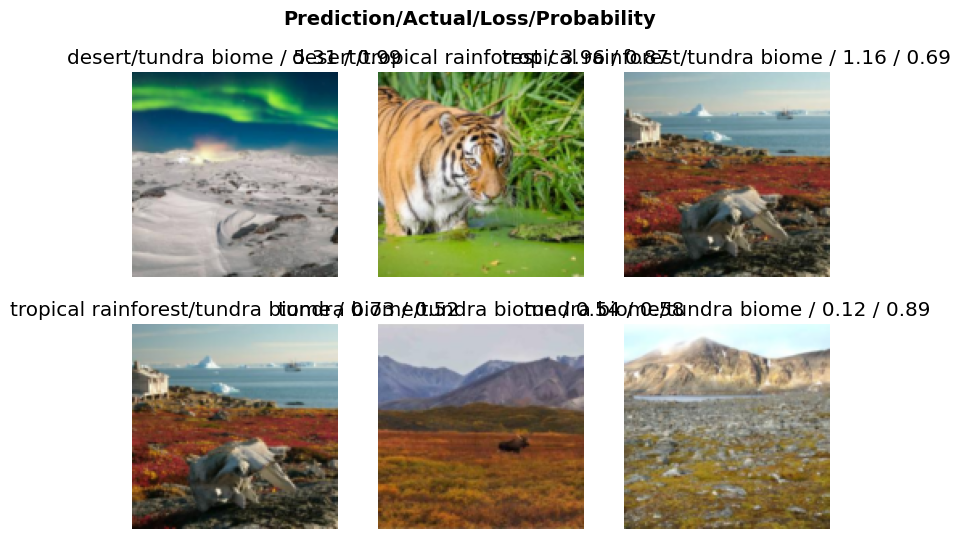

In [ ]:
interp.plot_top_losses(6, nrows=2)

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
fns = get_image_files(path)
fns

(#322) [Path('biomesPath/tundra biome/ab15ea49-92ad-45c3-8dd4-f0865325d60a.jpg'),Path('biomesPath/tundra biome/759027d7-e528-4545-b4b6-7aa234e297f2.jpg'),Path('biomesPath/tundra biome/98b576a4-43ff-4edd-bd2b-20176bf90303.jpg'),Path('biomesPath/tundra biome/b51aa564-158b-48bd-a178-26c00efc91ed.jpg'),Path('biomesPath/tundra biome/77702d83-642f-4d9c-a1ed-4764dd0ebf9c.jpg'),Path('biomesPath/tundra biome/a30724c8-cb10-4b36-bbed-abcd70baffeb.jpg'),Path('biomesPath/tundra biome/d2796e27-9c91-4661-9fb2-b8cd4944ed70.jpg'),Path('biomesPath/tundra biome/7706594f-9f78-4c75-be29-dfa68bad2dd6.jpg'),Path('biomesPath/tundra biome/d189b52e-a10f-4160-a910-ae55ddb44244.jpg'),Path('biomesPath/tundra biome/524863a0-e0ac-4c07-afd8-0e8d8879d4e6.jpg')...]

Let's train again with the cleaned data.

In [ ]:
biomes = biomes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = biomes.dataloaders(path)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


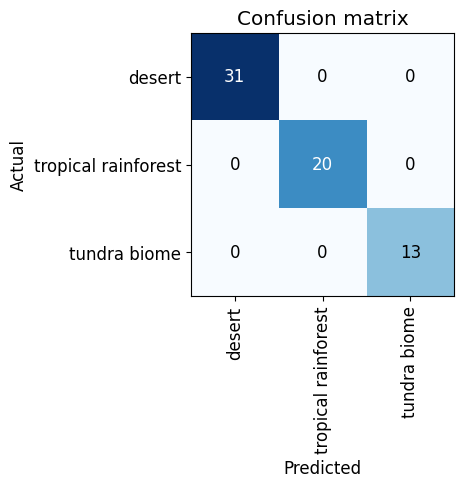

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

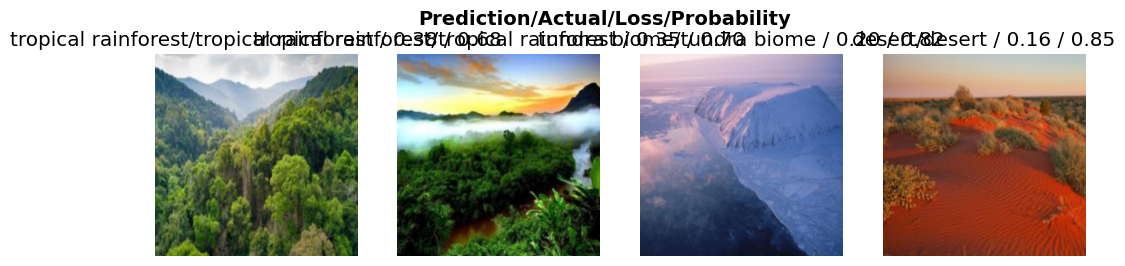

In [ ]:
interp.plot_top_losses(4, nrows=1)

We can observe that data cleaning has improved the accuracy of our model.

## Step 4: Deploy

Exporting the model:

In [ ]:
learn.export("model.pkl")

You can see here [huggingface](https://huggingface.co/spaces/fastaioncampus/Biome).

## Bibliographic References

---

[1] Course Fastai. Available at https://course.fast.ai/. Accessed on September 20, 2023

[2] Deep Learning for Coders with fastai & PyTorch. Available at  https://github.com/fastai/fastbook. Accessed on September 20, 2023

[3] Major types biomes. Available at https://education.nationalgeographic.org/resource/five-major-types-biomes/. Accessed on September 20, 2023
